<a href="https://colab.research.google.com/github/Jirtus-sanasam/MLP-Diabetes/blob/main/Diabetes5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:

# Step1: Import the required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                            roc_auc_score, roc_curve, accuracy_score)
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
import random
import time
import shap
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Step2: Read the Data
df = pd.read_csv("/content/diabetes_data2.csv")

In [15]:
# Step3: Separating Independent and Dependent Variables
X = df.drop("Outcome", axis=1)
Y = df["Outcome"]


In [16]:
# Step4: Split the data into training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
# Step6:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, Y_train)

In [19]:
# Creating Base MLP Model
mlp_baseline = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,

    # Learning rate and optimization
    learning_rate='adaptive',  # Adjusts learning rate when progress stalls
    learning_rate_init=0.001,  # Initial learning rate
    alpha=0.0001,  # L2 regularization term (helps prevent overfitting)

    # Early stopping
    early_stopping=True,  # Stop training when validation score isn't improving
    validation_fraction=0.1,  # Portion of training data for validation
    n_iter_no_change=10,  # Stop after this many iterations without improvement

    # Batch size and momentum
    batch_size='auto',  # Size of minibatches (or set specific number like 32, 64, 128)
    beta_1=0.9,  # Exponential decay rate for first moment (Adam solver)
    beta_2=0.999,  # Exponential decay rate for second moment (Adam solver)

    # Convergence and output
    tol=1e-4,  # Tolerance for optimization
    verbose=False,  # Set to True to see training progress
    warm_start=False  # Reuse previous solution to fit
)

In [20]:
# Training the Model
mlp_baseline.fit(X_train_balanced, y_train_balanced)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 50),
              learning_rate='adaptive', max_iter=1000, random_state=42)

In [28]:
# Predictions
y_pred_baseline = mlp_baseline.predict(X_test_scaled)

# Probabilities (safe method for models without predict_proba)
if hasattr(mlp_baseline, "predict_proba"):
    y_proba_baseline = mlp_baseline.predict_proba(X_test_scaled)[:, 1]
else:
    y_proba_baseline = mlp_baseline.decision_function(X_test_scaled)

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score
accuracy_baseline = accuracy_score(Y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(Y_test, y_proba_baseline)
precision_baseline = precision_score(Y_test, y_pred_baseline)
recall_baseline = recall_score(Y_test, y_pred_baseline)
f1_baseline = f1_score(Y_test, y_pred_baseline)

# Display results
print("\n=== Baseline MLP Performance ===")
print(f"Accuracy     : {accuracy_baseline:.4f}")
print(f"ROC-AUC      : {roc_auc_baseline:.4f}")
print(f"Precision    : {precision_baseline:.4f}")
print(f"Recall       : {recall_baseline:.4f}")
print(f"F1-Score     : {f1_baseline:.4f}")

print("\nClassification Report:")
print(classification_report(Y_test, y_pred_baseline))

# Optional: Confusion Matrix
cm = confusion_matrix(Y_test, y_pred_baseline)
print("\nConfusion Matrix:")
print(cm)



=== Baseline MLP Performance ===
Accuracy     : 0.7143
ROC-AUC      : 0.8154
Precision    : 0.5753
Recall       : 0.7636
F1-Score     : 0.6562

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76        99
           1       0.58      0.76      0.66        55

    accuracy                           0.71       154
   macro avg       0.71      0.73      0.71       154
weighted avg       0.75      0.71      0.72       154


Confusion Matrix:
[[68 31]
 [13 42]]


In [26]:
# GA Optimization
class MLPGeneticAlgorithm:
    def __init__(self, X_train, y_train, population_size=20, generations=15,
                 mutation_rate=0.15, cv_folds=3):
        self.X_train = X_train
        self.y_train = y_train
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.cv_folds = cv_folds

        # Define hyperparameter search space
        self.param_space = {
            'hidden_layer_sizes': [
                (64,), (128,), (256,),
                (64, 32), (128, 64), (256, 128),
                (128, 64, 32), (256, 128, 64)
            ],
            'activation': ['relu', 'tanh', 'logistic'],
            'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
            'learning_rate_init': [0.0001, 0.0005, 0.001, 0.005, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [1000, 1500, 2000, 2500],
            'batch_size': ['auto', 32, 64, 128, 256],
            'validation_fraction': [0.1, 0.15, 0.2],
            'n_iter_no_change': [10, 15, 20],
            'beta_1': [0.85, 0.9, 0.95],
            'beta_2': [0.99, 0.999],
            'early_stopping': [True, False]
        }

    def create_individual(self):
        """Create a random individual (set of hyperparameters)"""
        return {
            'hidden_layer_sizes': random.choice(self.param_space['hidden_layer_sizes']),
            'activation': random.choice(self.param_space['activation']),
            'alpha': random.choice(self.param_space['alpha']),
            'learning_rate_init': random.choice(self.param_space['learning_rate_init']),
            'learning_rate': random.choice(self.param_space['learning_rate']),
            'max_iter': random.choice(self.param_space['max_iter']),
            'batch_size': random.choice(self.param_space['batch_size']),
            'validation_fraction': random.choice(self.param_space['validation_fraction']),
            'n_iter_no_change': random.choice(self.param_space['n_iter_no_change']),
            'beta_1': random.choice(self.param_space['beta_1']),
            'beta_2': random.choice(self.param_space['beta_2']),
            'early_stopping': random.choice(self.param_space['early_stopping'])
        }

    def fitness(self, individual):
        """Evaluate fitness using cross-validation"""
        try:
            mlp = MLPClassifier(
                hidden_layer_sizes=individual['hidden_layer_sizes'],
                activation=individual['activation'],
                solver='adam',
                alpha=individual['alpha'],
                learning_rate_init=individual['learning_rate_init'],
                learning_rate=individual['learning_rate'],
                max_iter=individual['max_iter'],
                batch_size=individual['batch_size'],
                validation_fraction=individual['validation_fraction'],
                n_iter_no_change=individual['n_iter_no_change'],
                beta_1=individual['beta_1'],
                beta_2=individual['beta_2'],
                early_stopping=individual['early_stopping'],
                tol=1e-4,
                shuffle=True,
                random_state=42,
                verbose=False
            )

            # Use cross-validation for robust evaluation
            scores = cross_val_score(mlp, self.X_train, self.y_train,
                                    cv=self.cv_folds, scoring='accuracy', n_jobs=-1)
            return scores.mean()
        except Exception as e:
            print(f"Error in fitness evaluation: {e}")
            return 0.0

    def crossover(self, parent1, parent2):
        """Create offspring by combining two parents"""
        child = {}
        for key in parent1.keys():
            child[key] = parent1[key] if random.random() < 0.5 else parent2[key]
        return child

    def mutate(self, individual):
        """Randomly mutate an individual"""
        mutated = individual.copy()
        for key in mutated.keys():
            if random.random() < self.mutation_rate:
                mutated[key] = random.choice(self.param_space[key])
        return mutated

    def select_parents(self, population, fitness_scores):
        """Tournament selection"""
        tournament_size = 3
        selected = []
        for _ in range(2):
            tournament_indices = random.sample(range(len(population)), tournament_size)
            tournament = [(population[i], fitness_scores[i]) for i in tournament_indices]
            winner = max(tournament, key=lambda x: x[1])
            selected.append(winner[0])
        return selected[0], selected[1]

    def evolve(self):
        """Main GA loop"""
        print("="*70)
        print("GENETIC ALGORITHM HYPERPARAMETER OPTIMIZATION")
        print("="*70)
        print(f"Population Size: {self.population_size}")
        print(f"Generations: {self.generations}")
        print(f"Mutation Rate: {self.mutation_rate}")
        print(f"Cross-Validation Folds: {self.cv_folds}")
        print("="*70)

        # Initialize population
        population = [self.create_individual() for _ in range(self.population_size)]

        best_individual = None
        best_fitness = 0
        history = {'generation': [], 'best_fitness': [], 'avg_fitness': [], 'std_fitness': []}

        start_time = time.time()

        for generation in range(self.generations):
            gen_start = time.time()

            # Evaluate fitness
            print(f"\nEvaluating Generation {generation + 1}/{self.generations}...")
            fitness_scores = []
            for idx, ind in enumerate(population):
                score = self.fitness(ind)
                fitness_scores.append(score)
                if (idx + 1) % 5 == 0:
                    print(f"  Evaluated {idx + 1}/{self.population_size} individuals...")

            # Track best
            gen_best_idx = np.argmax(fitness_scores)
            if fitness_scores[gen_best_idx] > best_fitness:
                best_fitness = fitness_scores[gen_best_idx]
                best_individual = population[gen_best_idx].copy()

            # Store history
            history['generation'].append(generation + 1)
            history['best_fitness'].append(best_fitness)
            history['avg_fitness'].append(np.mean(fitness_scores))
            history['std_fitness'].append(np.std(fitness_scores))

            gen_time = time.time() - gen_start

            print(f"\n{'─'*70}")
            print(f"Generation {generation + 1} Summary:")
            print(f"{'─'*70}")
            print(f"  Best Fitness:    {best_fitness:.6f}")
            print(f"  Current Best:    {fitness_scores[gen_best_idx]:.6f}")
            print(f"  Average Fitness: {np.mean(fitness_scores):.6f}")
            print(f"  Std Fitness:     {np.std(fitness_scores):.6f}")
            print(f"  Time Taken:      {gen_time:.2f} seconds")
            print(f"\n  Best Parameters So Far:")
            for key, value in best_individual.items():
                print(f"    {key:25s}: {value}")
            print(f"{'─'*70}")

            # Create next generation
            new_population = []

            # Elitism: keep top 2 individuals
            elite_indices = np.argsort(fitness_scores)[-2:]
            for idx in elite_indices:
                new_population.append(population[idx])

            # Generate rest of population
            while len(new_population) < self.population_size:
                parent1, parent2 = self.select_parents(population, fitness_scores)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                new_population.append(child)

            population = new_population

        total_time = time.time() - start_time

        print("\n" + "="*70)
        print("OPTIMIZATION COMPLETE")
        print("="*70)
        print(f"Total Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
        print(f"Best Cross-Validation Accuracy: {best_fitness:.6f}")
        print(f"\nOptimal Hyperparameters:")
        print("─"*70)
        for key, value in best_individual.items():
            print(f"  {key:25s}: {value}")
        print("="*70)

        return best_individual, best_fitness, history


Starting GA Hyperparameter Tuning for MLP...
This may take several minutes depending on your settings.

GENETIC ALGORITHM HYPERPARAMETER OPTIMIZATION
Population Size: 20
Generations: 15
Mutation Rate: 0.15
Cross-Validation Folds: 3

Evaluating Generation 1/15...
  Evaluated 5/20 individuals...
  Evaluated 10/20 individuals...
  Evaluated 15/20 individuals...
  Evaluated 20/20 individuals...

──────────────────────────────────────────────────────────────────────
Generation 1 Summary:
──────────────────────────────────────────────────────────────────────
  Best Fitness:    0.770309
  Current Best:    0.770309
  Average Fitness: 0.739965
  Std Fitness:     0.031033
  Time Taken:      89.80 seconds

  Best Parameters So Far:
    hidden_layer_sizes       : (128,)
    activation               : tanh
    alpha                    : 0.01
    learning_rate_init       : 0.0001
    learning_rate            : adaptive
    max_iter                 : 2000
    batch_size               : 128
    valid

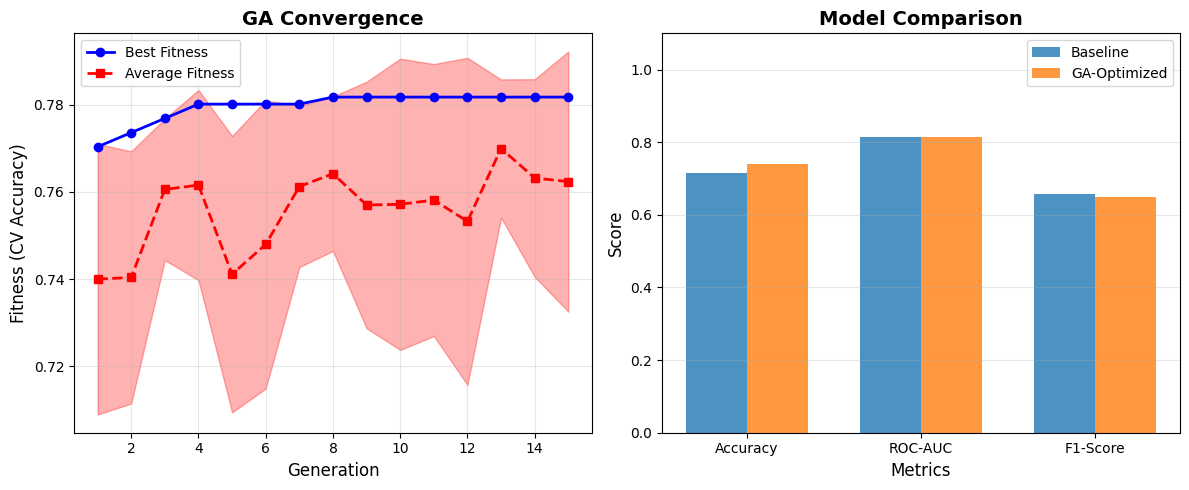


✓ GA Hyperparameter Tuning Complete!


In [29]:
# MAIN EXECUTION
# ============================================================================

print("\nStarting GA Hyperparameter Tuning for MLP...")
print("This may take several minutes depending on your settings.\n")

# Initialize GA optimizer
ga_optimizer = MLPGeneticAlgorithm(
    X_train_scaled,  # Your scaled training data
    Y_train,         # Your training labels
    population_size=20,  # Number of individuals per generation
    generations=15,      # Number of generations to evolve
    mutation_rate=0.15,  # Probability of mutation
    cv_folds=3          # Cross-validation folds
)

# Run optimization
best_params, best_score, ga_history = ga_optimizer.evolve()

# ============================================================================
# TRAIN FINAL MODEL WITH BEST PARAMETERS
# ============================================================================

print("\n" + "="*70)
print("TRAINING FINAL MODEL WITH OPTIMIZED PARAMETERS")
print("="*70)

final_mlp_optimized = MLPClassifier(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    activation=best_params['activation'],
    solver='adam',
    alpha=best_params['alpha'],
    learning_rate_init=best_params['learning_rate_init'],
    learning_rate=best_params['learning_rate'],
    max_iter=best_params['max_iter'],
    batch_size=best_params['batch_size'],
    validation_fraction=best_params['validation_fraction'],
    n_iter_no_change=best_params['n_iter_no_change'],
    beta_1=best_params['beta_1'],
    beta_2=best_params['beta_2'],
    early_stopping=best_params['early_stopping'],
    tol=1e-4,
    shuffle=True,
    random_state=42,
    verbose=True
)

# Train on full training set
final_mlp_optimized.fit(X_train_scaled, Y_train)

# ============================================================================
# EVALUATE ON TEST SET
# ============================================================================

print("\n" + "="*70)
print("FINAL MODEL EVALUATION")
print("="*70)

y_pred_optimized = final_mlp_optimized.predict(X_test_scaled)
y_pred_proba_optimized = final_mlp_optimized.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,
                             precision_score, recall_score, f1_score, matthews_corrcoef)

accuracy_optimized = accuracy_score(Y_test, y_pred_optimized)
roc_auc_optimized = roc_auc_score(Y_test, y_pred_proba_optimized)
precision_optimized = precision_score(Y_test, y_pred_optimized)
recall_optimized = recall_score(Y_test, y_pred_optimized)
f1_optimized = f1_score(Y_test, y_pred_optimized)
mcc_optimized = matthews_corrcoef(Y_test, y_pred_optimized)

print(f"\nOptimized MLP Performance:")
print(f"  Accuracy:  {accuracy_optimized:.6f}")
print(f"  ROC-AUC:   {roc_auc_optimized:.6f}")
print(f"  Precision: {precision_optimized:.6f}")
print(f"  Recall:    {recall_optimized:.6f}")
print(f"  F1-Score:  {f1_optimized:.6f}")
print(f"  MCC:       {mcc_optimized:.6f}")

# Re-evaluate baseline metrics in this cell to ensure they are defined for comparison and plotting
# This is a defensive measure in case previous cell's outputs were lost from scope.
# Variables y_pred_baseline and y_proba_baseline are expected to be available from the execution of GQrwwPsjc_RG
accuracy_baseline = accuracy_score(Y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(Y_test, y_proba_baseline)
f1_baseline = f1_score(Y_test, y_pred_baseline)

print(f"\nComparison with Baseline:")
print(f"  Accuracy Improvement:  {(accuracy_optimized - accuracy_baseline)*100:+.2f}%")
print(f"  ROC-AUC Improvement:   {(roc_auc_optimized - roc_auc_baseline)*100:+.2f}%")

print("\n" + "="*70)
print("Classification Report:")
print("="*70)
print(classification_report(Y_test, y_pred_optimized))

# ============================================================================
# PLOT GA CONVERGENCE
# ============================================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ga_history['generation'], ga_history['best_fitness'], 'b-o', linewidth=2, label='Best Fitness')
plt.plot(ga_history['generation'], ga_history['avg_fitness'], 'r--s', linewidth=2, label='Average Fitness')
plt.fill_between(ga_history['generation'],
                 np.array(ga_history['avg_fitness']) - np.array(ga_history['std_fitness']),
                 np.array(ga_history['avg_fitness']) + np.array(ga_history['std_fitness']),
                 alpha=0.3, color='red')
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Fitness (CV Accuracy)', fontsize=12)
plt.title('GA Convergence', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
metrics_comparison = {
    'Baseline': [accuracy_baseline, roc_auc_baseline, f1_baseline],
    'GA-Optimized': [accuracy_optimized, roc_auc_optimized, f1_optimized]
}
x = np.arange(3)
width = 0.35
plt.bar(x - width/2, metrics_comparison['Baseline'], width, label='Baseline', alpha=0.8)
plt.bar(x + width/2, metrics_comparison['GA-Optimized'], width, label='GA-Optimized', alpha=0.8)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Model Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, ['Accuracy', 'ROC-AUC', 'F1-Score'])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

print("\n✓ GA Hyperparameter Tuning Complete!")